# Inicjalizacja danych

In [24]:
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d 
from scipy.signal import find_peaks
from scipy import integrate

In [25]:
sns.set(rc={'figure.figsize':(12.0, 5.0), 'errorbar.capsize':10, 'figure.dpi':96})
sns.set_context("paper")
sns.set(style="ticks")


CONST_CHAR_AMP_MEAN = "I$_{średnio}$ [A]"
CONST_CHAR_AMP_MAX = "I$_{max}$ [A]"
CONST_CHAR_AMP_MIN = "I$_{min}$ [A]"
CONST_CHAR_ENERGY = "E [J]"
CONST_CHAR_POWER = "P [mW]"

CONST_CHAR_AMP_MEAN_MILLIAMP = "I$_{średnio}$ [mA]"
CONST_CHAR_AMP_MAX_MILLIAMP = "I$_{max}$ [mA]"
CONST_CHAR_AMP_MIN_MILLIAMP = "I$_{min}$ [mA]"

CONST_AMPERAGE = "Chwilowe natężenie prądu [uA]"
CONST_TIMESTAMP = "Podstawa czasu [ms]"
CONST_CATEGORY = "Kategoria"

CONST_CAT_HRT_CONNECTED = "HRT Połączone"
CONST_CAT_HRT_DISCOVERY = "HRT Discovery"
CONST_CAT_HRT_LONG_DISCOVERY = "HRT Long Discovery"
CONST_CAT_MESH_PING_1300MS = "Mesh: interwał zapytań=1300ms"
CONST_CAT_MESH_STANDBY = "Mesh: w gotowości"


def rename_columns(df:pd.DataFrame, current, new_names):
    columns = dict(zip(current, new_names))
    df.rename(columns=columns, inplace=True)
    
def compute_signal_characteristics(data, **params):
    uA_to_A = 10**-6
    volts_V = 3.3
    sampling_interval_s = np.diff(data[CONST_TIMESTAMP]).max() * 0.001 # millis per seconds
    duration_s = (params["duration_ms"] if "duration_ms" in params else data[CONST_TIMESTAMP].max()) * 0.001
    coef = volts_V * sampling_interval_s * uA_to_A
    # Energy = Volts * integral(dTime * dCurrent)
    total_J = coef * integrate.simpson(data[CONST_AMPERAGE])
    power_mWatts = (total_J / duration_s) * 10**3 
    
    amp_mean = data[CONST_AMPERAGE].mean() * uA_to_A
    amp_max = data[CONST_AMPERAGE].max() * uA_to_A
    amp_min = data[CONST_AMPERAGE].min() * uA_to_A
    return {
        CONST_CHAR_AMP_MEAN: amp_mean,
        CONST_CHAR_AMP_MAX: amp_max,
        CONST_CHAR_AMP_MIN: amp_min,
        CONST_CHAR_ENERGY: total_J,
        CONST_CHAR_POWER: power_mWatts,
    }

def signal_characteristics_with_categories(data):
    results = []
    for category in pd.unique(data[CONST_CATEGORY]):
        data_category = data[data[CONST_CATEGORY] == category]
        result = compute_signal_characteristics(data_category)
        result[CONST_CATEGORY] = category
        results.append(result)
        
    return pd.DataFrame(results)

def convert_amps_to_milli(data):
    affected_cols = [CONST_CHAR_AMP_MEAN, CONST_CHAR_AMP_MAX, CONST_CHAR_AMP_MIN]
    data[affected_cols] = data[affected_cols].apply(lambda x: x*1000)
    rename_columns(data, (CONST_CHAR_AMP_MEAN, CONST_CHAR_AMP_MAX, CONST_CHAR_AMP_MIN, CONST_CHAR_ENERGY, CONST_CATEGORY), 
               (CONST_CHAR_AMP_MEAN_MILLIAMP, CONST_CHAR_AMP_MAX_MILLIAMP, CONST_CHAR_AMP_MIN_MILLIAMP, CONST_CHAR_ENERGY, CONST_CATEGORY))

def compute_extrema(data, window:int):
    x_extrema = []
    y_extrema = []
    categories = []
    for category in pd.unique(data[CONST_CATEGORY]):
        data_cat = data[data[CONST_CATEGORY] == category]
        y_values = data_cat[CONST_AMPERAGE].to_numpy()
        x_values = data_cat[CONST_TIMESTAMP].to_numpy()
        cat_values = data_cat[CONST_CATEGORY].to_numpy()
        
        peaks, _ = find_peaks(y_values, distance=window)
        mins, _ = find_peaks(y_values*-1, distance=window)
        x_extrema.append(x_values[np.concatenate([mins,peaks])])
        y_extrema.append(y_values[np.concatenate([mins,peaks])])
        categories.append(cat_values[np.concatenate([mins,peaks])])
    return pd.DataFrame({
        CONST_TIMESTAMP: np.concatenate(x_extrema), 
        CONST_AMPERAGE: np.concatenate(y_extrema), 
        CONST_CATEGORY: np.concatenate(categories)
    })

def compute_interpolation(data, multiplier:float):
    x = []
    y = []
    categories = []
    for category in pd.unique(data[CONST_CATEGORY]):
        data_cat = data[data[CONST_CATEGORY] == category]
        y_values = data_cat[CONST_AMPERAGE].to_numpy()
        x_values = data_cat[CONST_TIMESTAMP].to_numpy()
        cat_values = data_cat[CONST_CATEGORY].to_numpy()
        
        interp_count=int(len(x_values) * multiplier)
        x_interp = np.linspace(x_values.min(), x_values.max(), interp_count)
        # methods = ['linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next']
        y_interp = interp1d(x_values, y_values, kind = "nearest-up")(x_interp)
        
        x.append(np.array(x_interp))
        y.append(np.array(y_interp))
        categories.append(np.array([category for _ in range(len(x_interp))]))
        
    return pd.DataFrame({
        CONST_TIMESTAMP: np.concatenate(x), 
        CONST_AMPERAGE: np.concatenate(y), 
        CONST_CATEGORY: np.concatenate(categories)
    })

def plot_with_interpolation(data, title, window, interp_multiplier, dot_size):    
    p = compute_extrema(data, window)
    l = compute_interpolation(p, interp_multiplier)   
    dot_sizes = [dot_size for _ in range(len(pd.unique(data[CONST_CATEGORY])))]
    print(f"dot_sizes={dot_sizes}")
    fig, ax = plt.subplots()
    # g = sns.scatterplot(data=p, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, ax=ax)
    l = sns.lineplot(data=l, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, ax=ax, style=CONST_CATEGORY)
    gg = sns.scatterplot(data=data, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, ax=ax, style=CONST_CATEGORY, size=CONST_CATEGORY, sizes=dot_sizes)
    # g.legend(loc="center left", bbox_to_anchor=(1, .5))
    l.legend(loc="center left", bbox_to_anchor=(1, .5))
    gg.legend(loc="center left", bbox_to_anchor=(1, .5))
    
    ax.grid(True, axis='both')            
    # X Axis arrow
    ax.annotate('', xy=(1.01, 0.0), xytext=(-0.001, 0.0), xycoords="axes fraction",
        weight='bold', color="k", arrowprops=dict(arrowstyle='->', color="k"), annotation_clip=False)
    # Y Axis arrow
    ax.annotate('', xy=(0.002, 1.03), xytext=(0.002, -0.006), xycoords="axes fraction",
        weight='bold', color="k", arrowprops=dict(arrowstyle='->', color="k"), annotation_clip=False)
    plt.title(title, fontdict={"fontsize": 15})
    sns.despine(left=True, bottom=True, top=True, right=True)
    plt.show()

ble_hrt_connected = pd.read_csv("ble_hrt_connected.csv", delimiter=';')
ble_hrt_discovery = pd.read_csv("ble_hrt_discovery.csv", delimiter=';')  
ble_hrt_long_discovery = pd.read_csv("ble_hrt_long_discovery.csv", delimiter=';')
ble_mesh_ping_1300 = pd.read_csv("ble_mesh_ping_1300.csv", delimiter=';')
ble_mesh_standby = pd.read_csv("ble_mesh_standby.csv", delimiter=';')

rename_columns(ble_hrt_connected, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_hrt_discovery, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_hrt_long_discovery, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_mesh_ping_1300, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_mesh_standby, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))

ble_hrt_connected[CONST_CATEGORY] = CONST_CAT_HRT_CONNECTED
ble_hrt_discovery[CONST_CATEGORY] = CONST_CAT_HRT_DISCOVERY
ble_hrt_long_discovery[CONST_CATEGORY] = CONST_CAT_HRT_LONG_DISCOVERY
ble_mesh_ping_1300[CONST_CATEGORY] = CONST_CAT_MESH_PING_1300MS
ble_mesh_standby[CONST_CATEGORY] = CONST_CAT_MESH_STANDBY

data_hrt = pd.concat([ble_hrt_connected, ble_hrt_discovery, ble_hrt_long_discovery])
data_mesh = pd.concat([ble_mesh_ping_1300, ble_mesh_standby])

# Przegląd danych

size=5000


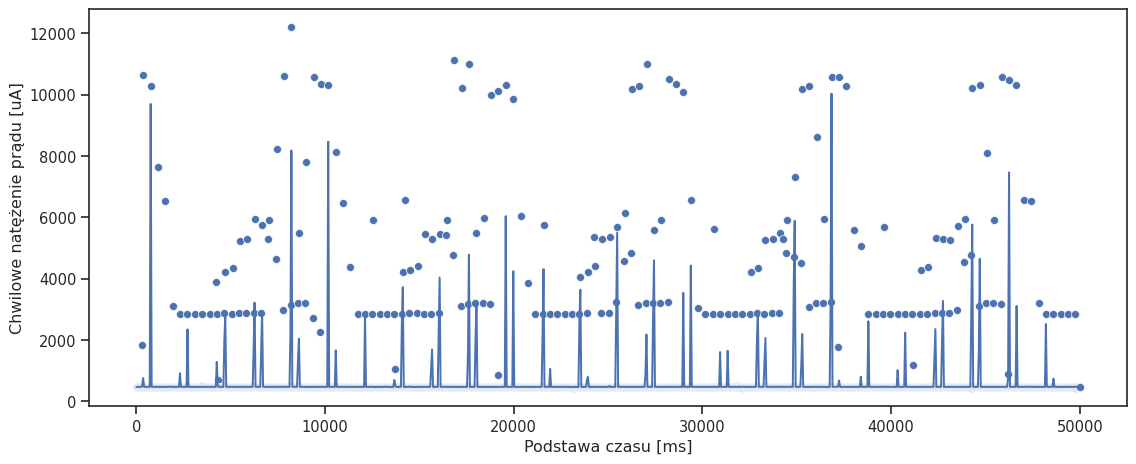

In [26]:
# sns.pointplot(data=ble_hrt_connected, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, linestyles="none")
print(f"size={len(ble_hrt_connected)}")

x = ble_hrt_connected[CONST_TIMESTAMP]
y =  ble_hrt_connected[CONST_AMPERAGE]
x_interp = np.linspace(x.min(), x.max(), 1000)
methods = ['linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next']
fig, ax = plt.subplots()
y_interp = interp1d(x, y, kind = "linear")(x_interp)
sns.lineplot(x=x_interp, y=y_interp, ax = ax)
sns.scatterplot(x=x, y=y, ax = ax)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Podstawa czasu [ms]', ylabel='Chwilowe natężenie prądu [uA]'>

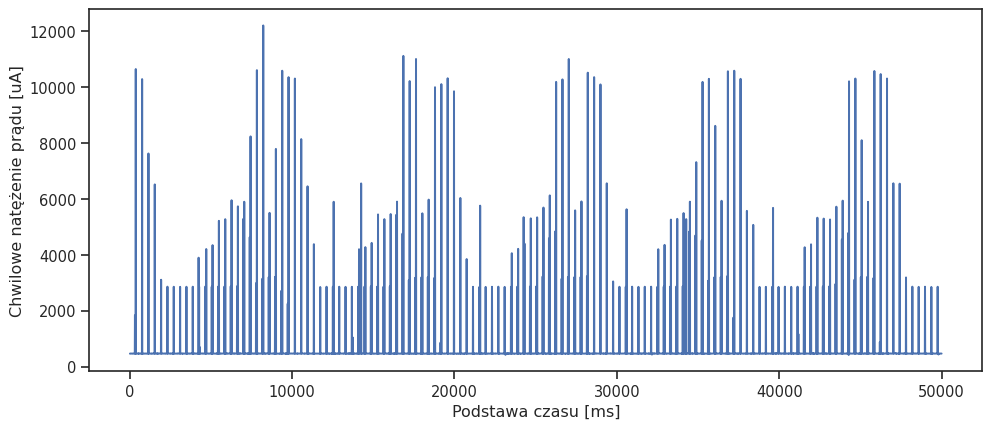

In [27]:
sns.lineplot(data=ble_hrt_connected, x=CONST_TIMESTAMP, y=CONST_AMPERAGE)

<AxesSubplot:xlabel='Podstawa czasu [ms]', ylabel='Chwilowe natężenie prądu [uA]'>

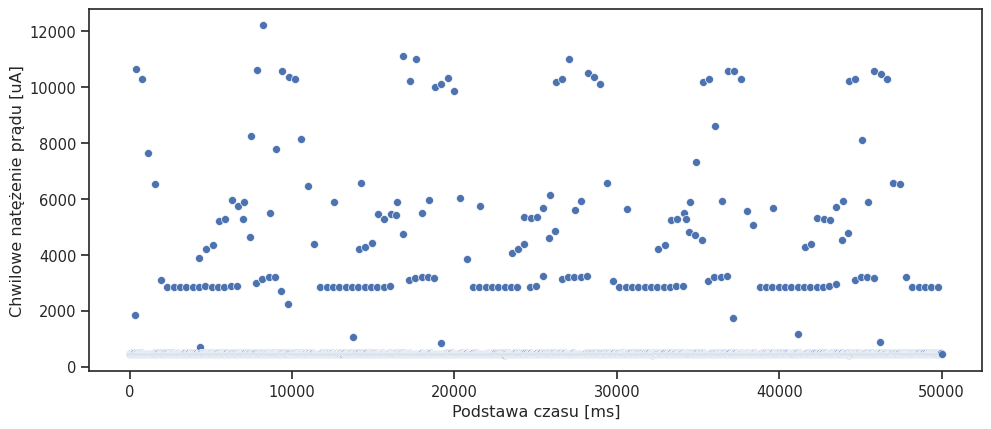

In [28]:
sns.scatterplot(data=ble_hrt_connected, x=CONST_TIMESTAMP, y=CONST_AMPERAGE)

<AxesSubplot:xlabel='Podstawa czasu [ms]', ylabel='Chwilowe natężenie prądu [uA]'>

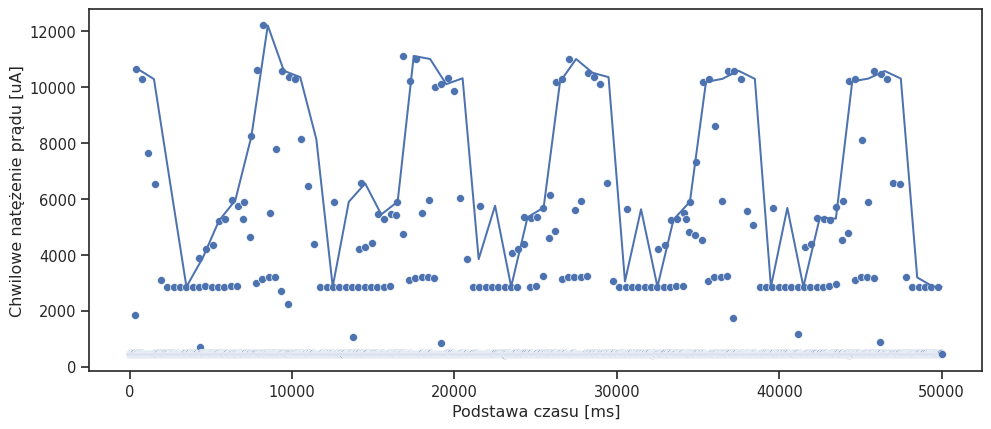

In [29]:
downsampled = ble_hrt_connected.groupby(ble_hrt_connected[CONST_TIMESTAMP].apply(lambda x: 1000*round(x/1000))).max()
# y = interp1d(downsampled[CONST_TIMESTAMP], downsampled[CONST_AMPERAGE], kind="linear")(downsampled[CONST_TIMESTAMP])
sns.scatterplot(data=ble_hrt_connected,x=CONST_TIMESTAMP, y=CONST_AMPERAGE)
sns.lineplot(data=downsampled, x=CONST_TIMESTAMP, y=CONST_AMPERAGE)

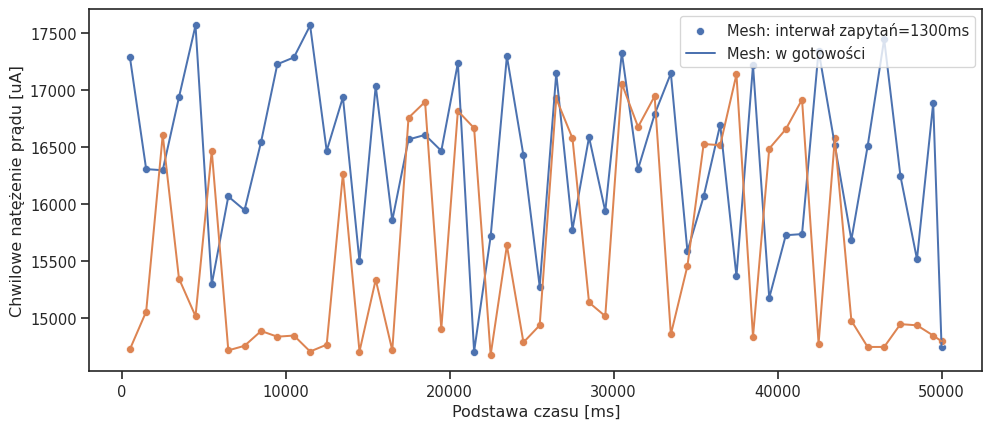

In [30]:
# sns.relplot(x=CONST_TIMESTAMP, y=CONST_AMPERAGE, data=data_mesh, hue=CONST_CATEGORY, col=CONST_CATEGORY, kind="line")

def plot(data):
    sampling = 1000
    categories = pd.unique(data[CONST_CATEGORY])
    values = pd.DataFrame()
    fig, ax = plt.subplots()
    for category in categories:
        data_category = data[data[CONST_CATEGORY] == category]
        downsampled = data_category.groupby(data_category[CONST_TIMESTAMP].apply(lambda x: sampling*round(x/sampling))).max()
        values = pd.concat([values, downsampled])
        s = sns.scatterplot(data=downsampled,x=CONST_TIMESTAMP, y=CONST_AMPERAGE, legend=False)
        l = sns.lineplot(data=downsampled, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, legend=False)
    
    plt.legend(labels=categories, loc="upper right")
    # ax.legend("upper right", bbox_to_anchor=(1, 1))
    
    # g = sns.catplot(data=values,x=CONST_TIMESTAMP, y=CONST_AMPERAGE, kind="point", estimator=np.median, ci=None)
    # for ind, label in enumerate(g.ax.get_xticklabels()):
    #     if ind % sampling == 0:  # every 10th label is kept
    #         label.set_visible(True)
    #         label.set_rotation(90)
    #     else:
    #         label.set_visible(False)

# plot(data_mesh[data_mesh[CONST_CATEGORY] == "Mesh: interwał zapytań=1300ms"])
plot(data_mesh)

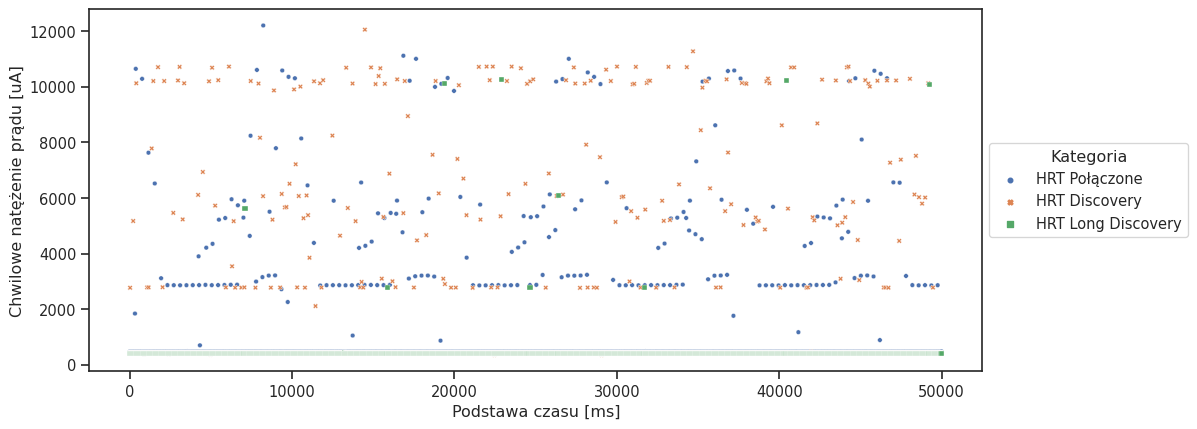

In [31]:
# g = sns.lineplot(data=data_mesh[data_mesh[CONST_CATEGORY] == "Mesh: interwał zapytań=1300ms"], x=CONST_TIMESTAMP, y=CONST_AMPERAGE)
g = sns.scatterplot(data=data_hrt, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, style=CONST_CATEGORY, size=CONST_CATEGORY, sizes=[12, 14, 30])
sns.move_legend(g, "center left", bbox_to_anchor=(1, .5))

In [32]:
# sns.lineplot(data=data_mesh[data_mesh[CONST_CATEGORY] == "Mesh: w gotowości"], x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY)
# sns.lineplot(data=data_mesh, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY)
# fig = px.scatter(data_mesh, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, color=CONST_CATEGORY, trendline="lowess", trendline_options=dict(frac=0.005),
#                 title="Rolling Median")
# fig.data = [t for t in fig.data if t.mode == "lines"]
# fig.update_traces(showlegend=True) #trendlines have showlegend=False by default
fig = px.scatter(data_hrt, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, color=CONST_CATEGORY, trendline="rolling", trendline_options=dict(function="max", window=15))
                
# fig.data = [t for t in fig.data if t.mode == "lines"]
# fig.update_traces(showlegend=True) #trendlines have showlegend=False by default
fig.show()

In [33]:
fig = px.scatter(data_mesh, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, color=CONST_CATEGORY, trendline="rolling", trendline_options=dict(function="max", window=15))
                
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True) #trendlines have showlegend=False by default
fig.show()

extrema_count=981
dot_sizes=[2, 2]


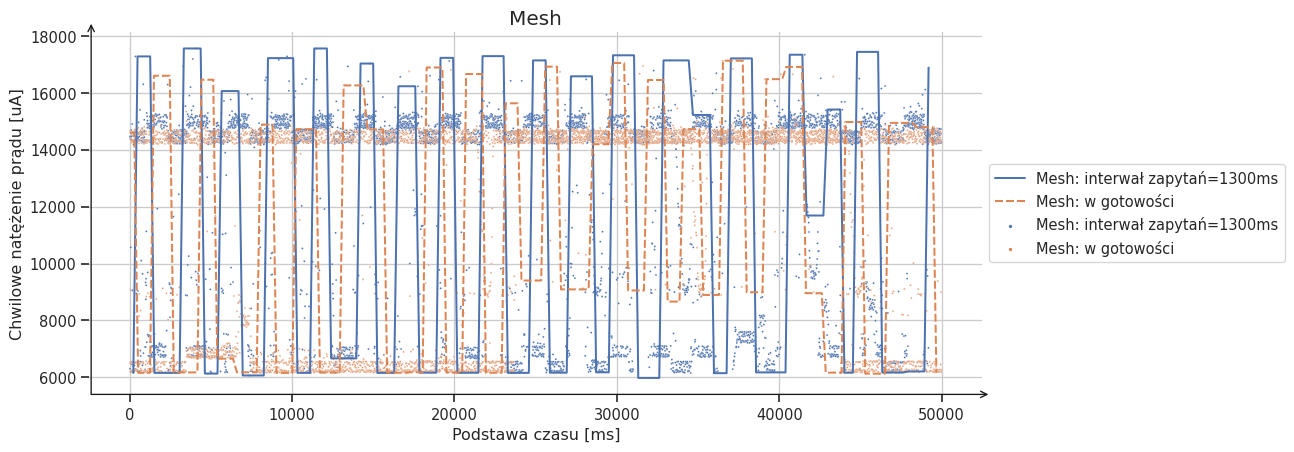

In [34]:
# from scipy.signal import find_peaks

y_values = data_mesh[CONST_AMPERAGE].to_numpy()
x_values = data_mesh[CONST_TIMESTAMP].to_numpy()

peaks, _ = find_peaks(y_values, distance=15)
mins, _ = find_peaks(y_values*-1, distance=15)
# x = np.linspace(0, 100, len(derivation))
# plt.plot(x_values, derivation, color='black');
# plt.plot(x_values[mins], derivation[mins], 'x', label='mins')
# plt.plot(x_values[peaks], derivation[peaks], '*', label='peaks')
# plt.plot(x_values[np.concatenate([mins,peaks])], derivation[np.concatenate([mins,peaks])], '*', label='p')
# plt.legend()
x_extrema = x_values[np.concatenate([mins,peaks])]
y_extrema = y_values[np.concatenate([mins,peaks])]
interp_count=len(x_extrema) // 10
print(f"extrema_count={len(x_extrema)}")

x_interp = np.linspace(x_extrema.min(), x_extrema.max(), interp_count)
# methods = ['linear', 'nearest', 'nearest-up', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next']
# fig, ax = plt.subplots()
y_interp = interp1d(x_extrema, y_extrema, kind = "zero")(x_interp)
# sns.lineplot(x=x_interp, y=y_interp)
    
# p = compute_extrema(data_mesh, 200)
# l = compute_interpolation(p, 5)                          
# print(f"p={len(p)} l={len(l)}")
# sns.set(rc={'figure.figsize':(12.0, 5.0)})
# fig, ax = plt.subplots()
# # g = sns.scatterplot(data=p, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, ax=ax)
# l = sns.lineplot(data=l, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, ax=ax)
# gg = sns.scatterplot(data=data_mesh, x=CONST_TIMESTAMP, y=CONST_AMPERAGE, hue=CONST_CATEGORY, ax=ax, style=CONST_CATEGORY, size=CONST_CATEGORY, sizes=[2, 2])
# g.legend(loc="center left", bbox_to_anchor=(1, .5))
# l.legend(loc="center left", bbox_to_anchor=(1, .5))
# gg.legend(loc="center left", bbox_to_anchor=(1, .5))
# plt.show()

# default: figure.figsize: [6.0, 4.0]
#from matplotlib import rcParams
#print(rcParams)

plot_with_interpolation(data_mesh, "Mesh", 200, 5, 2)

dot_sizes=[8, 8, 8]


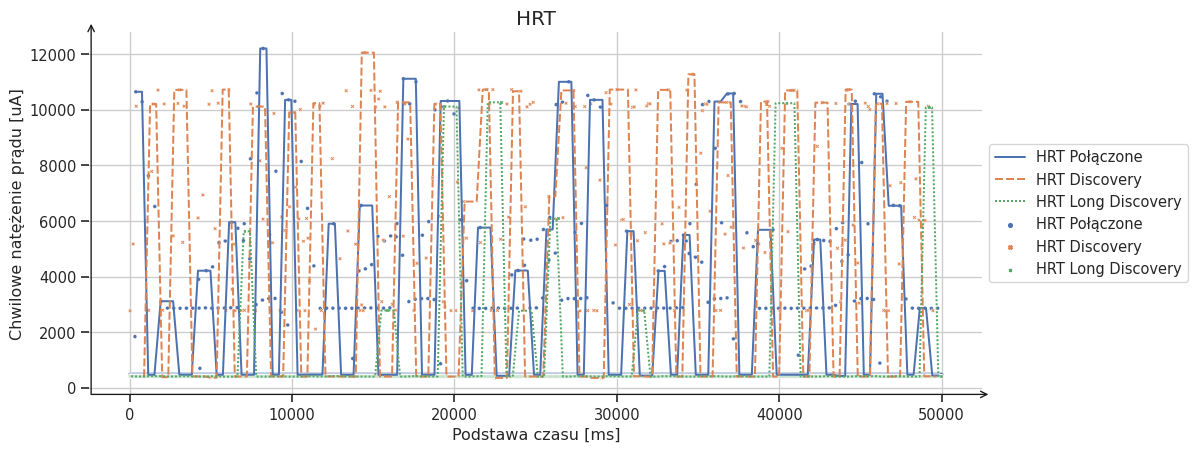

In [35]:
plot_with_interpolation(data_hrt, "HRT", 150, 2.5, 8)

In [36]:
mesh_1300ms = pd.read_csv("2022_05_06_18_40_32_16_rawfile_1.csv", delimiter=";")
rename_columns(mesh_1300ms, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
# 3.3 * integrate.simpson(mesh_1300ms[CONST_AMPERAGE]) / 50.0
amp_mean = mesh_1300ms[CONST_AMPERAGE].mean()
amp_max = mesh_1300ms[CONST_AMPERAGE].max()
amp_min = mesh_1300ms[CONST_AMPERAGE].min()

print(f"amp_mean={amp_mean}, amp_max={amp_max} amp_min={amp_min}")

en=4177343.9070000174
en=4162606.8109999998

# amp_mean * 3.3
uA_to_A = 10**-6
volts = 3.3
sampling_interval = np.diff(mesh_1300ms[CONST_TIMESTAMP]).max() / 1000 # millis per seconds
coef = volts * sampling_interval * uA_to_A
total_J = integrate.simpson(coef * mesh_1300ms[CONST_AMPERAGE])

print(f"coef={coef} sampling_interval={sampling_interval} total_J={total_J}")
total_J * 10**6
# amp_mean * 3.3 * 100

compute_signal_characteristics(data_mesh[data_mesh[CONST_CATEGORY] == CONST_CAT_MESH_STANDBY])

amp_mean=12658.6179, amp_max=17570.0 amp_min=5973.0
coef=3.3e-08 sampling_interval=0.01 total_J=4.17698500725


{'I$_{średnio}$ [A]': 0.0120457252,
 'I$_{max}$ [A]': 0.01714,
 'I$_{min}$ [A]': 0.006123,
 'E [J]': 1.9871992277499997,
 'P [mW]': 39.74398455499999}

# Analiza danych

## Bluetooth Low Energy - Usługa Heart Rate

### Charakterystyka dynamiczna poboru prądu

dot_sizes=[8]


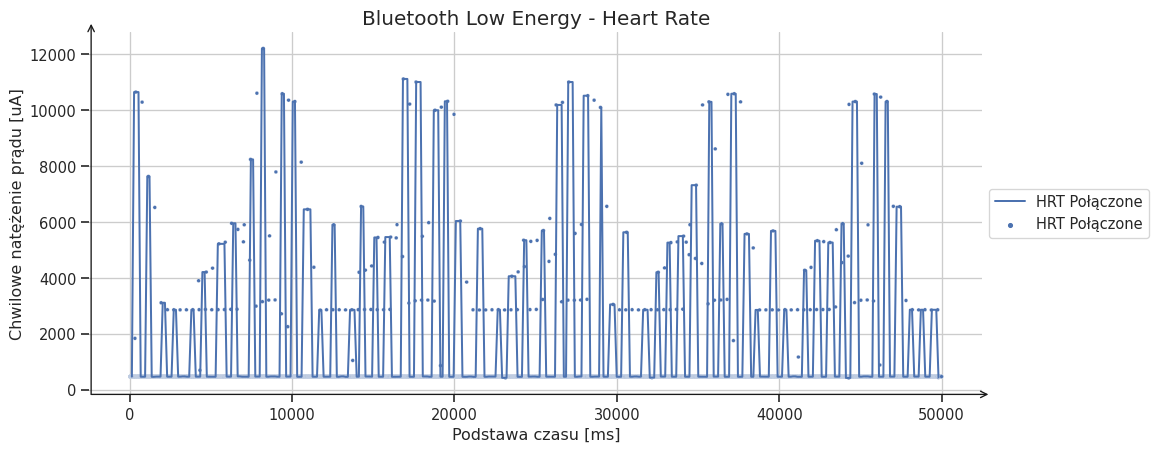

In [37]:
# plot_with_interpolation(data_hrt, "Bluetooth Low Energy - Heart Rate", 50, 2.5, 8) # rozbić wykres na 3 mniejsze + opis do każdego z nich
plot_with_interpolation(data_hrt[data_hrt[CONST_CATEGORY] == CONST_CAT_HRT_CONNECTED], "Bluetooth Low Energy - Heart Rate", 50, 2.5, 8)

dot_sizes=[8]


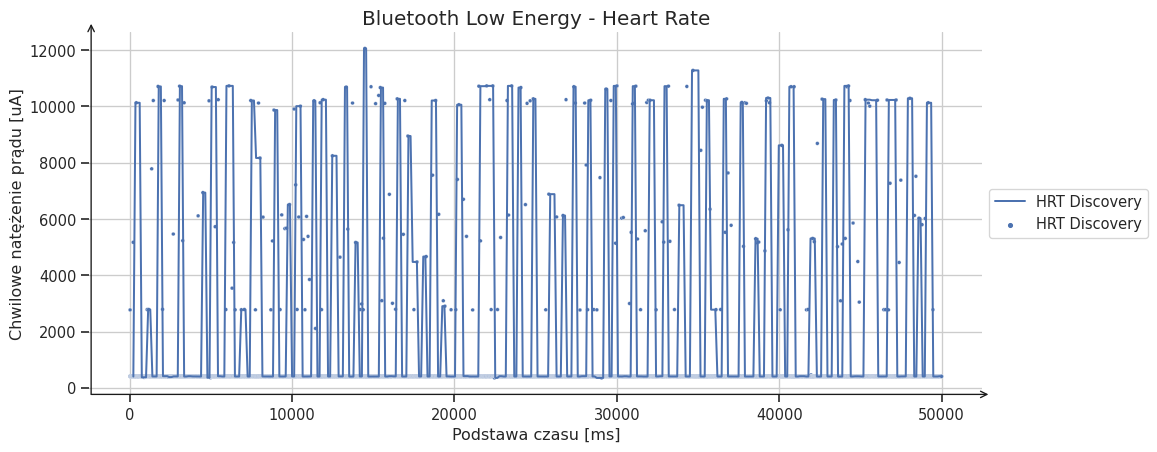

In [38]:
plot_with_interpolation(data_hrt[data_hrt[CONST_CATEGORY] == CONST_CAT_HRT_DISCOVERY], "Bluetooth Low Energy - Heart Rate", 50, 2.5, 8)

dot_sizes=[8]


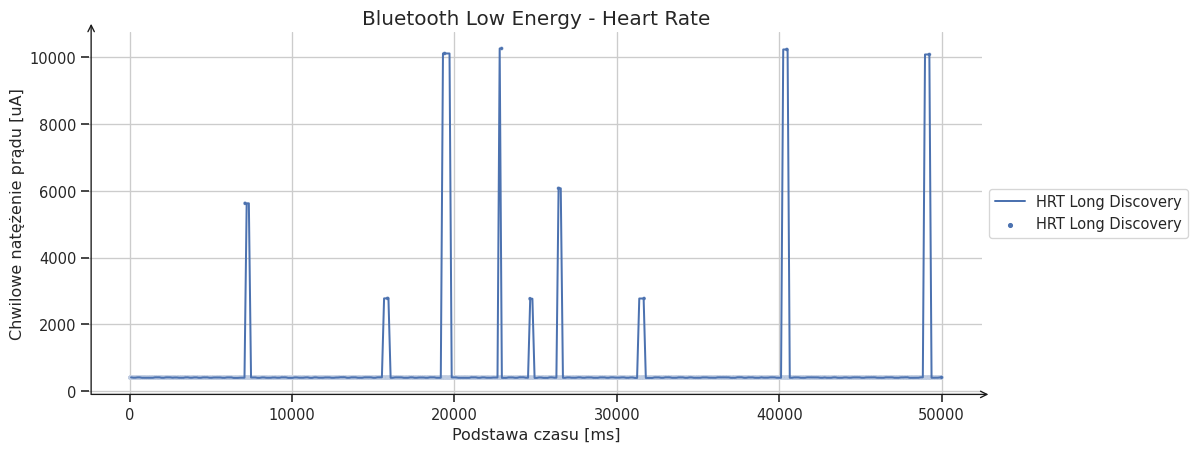

In [39]:
plot_with_interpolation(data_hrt[data_hrt[CONST_CATEGORY] == CONST_CAT_HRT_LONG_DISCOVERY], "Bluetooth Low Energy - Heart Rate", 50, 2.5, 8)

### Punkty charakterystyczne dla danych

I$_{średnio}$ [mA]  I$_{max}$ [mA]  I$_{min}$ [mA]     E [J]    P [mW]  \
0            0.653928           12.21          0.4216  0.107883  2.157655   
1            0.689138           12.06          0.3500  0.113701  2.274017   
2            0.417069           10.27          0.3955  0.068803  1.376061   

            Kategoria  
0       HRT Połączone  
1       HRT Discovery  
2  HRT Long Discovery

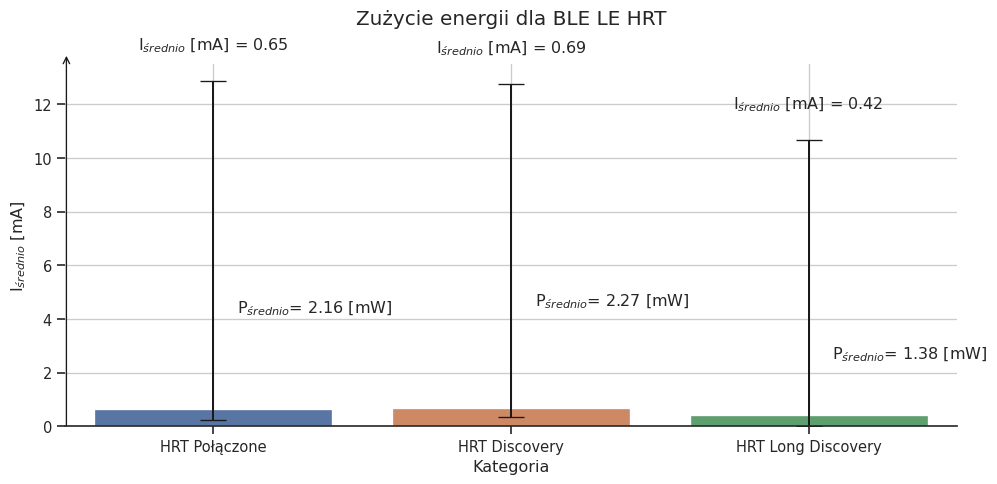

In [40]:
hrt_char = signal_characteristics_with_categories(data_hrt)
convert_amps_to_milli(hrt_char)

yerr = [hrt_char[CONST_CHAR_AMP_MIN_MILLIAMP], hrt_char[CONST_CHAR_AMP_MAX_MILLIAMP]]
ax = sns.barplot(data=hrt_char, x=CONST_CATEGORY, y=CONST_CHAR_AMP_MEAN_MILLIAMP, yerr=yerr)
ax.bar_label(ax.containers[-1], fmt=CONST_CHAR_AMP_MEAN_MILLIAMP + " = %.02f", label_type='edge', padding=20)
for p,energy,pwr in zip(ax.patches, hrt_char[CONST_CHAR_ENERGY], hrt_char[CONST_CHAR_POWER]):
    # ax.annotate("E$_{średnio}$ = %.02f [J]" % energy, xy=(p.get_x()+3*p.get_width()/5, p.get_height() * 6), ha='left', va='top')
    ax.annotate("P$_{średnio}$= %.02f [mW]" % pwr, xy=(p.get_x()+3*p.get_width()/5, p.get_height() * 7.25), ha='left', va='top')
ax.grid(True, axis='both')      
sns.despine(top=True, right=True, left=True)
# Y Axis arrow
ax.annotate('', xy=(0.002, 1.03), xytext=(0.002, -0.006), xycoords="axes fraction",
    weight='bold', color="k", arrowprops=dict(arrowstyle='->', color="k"), annotation_clip=False)
plt.title("Zużycie energii dla BLE LE HRT", fontdict={"fontsize": 15}, pad=30)
hrt_char

## Bluetooth Low Energy - Mesh

### Charakterystyka dynamiczna poboru prądu

dot_sizes=[2, 2]


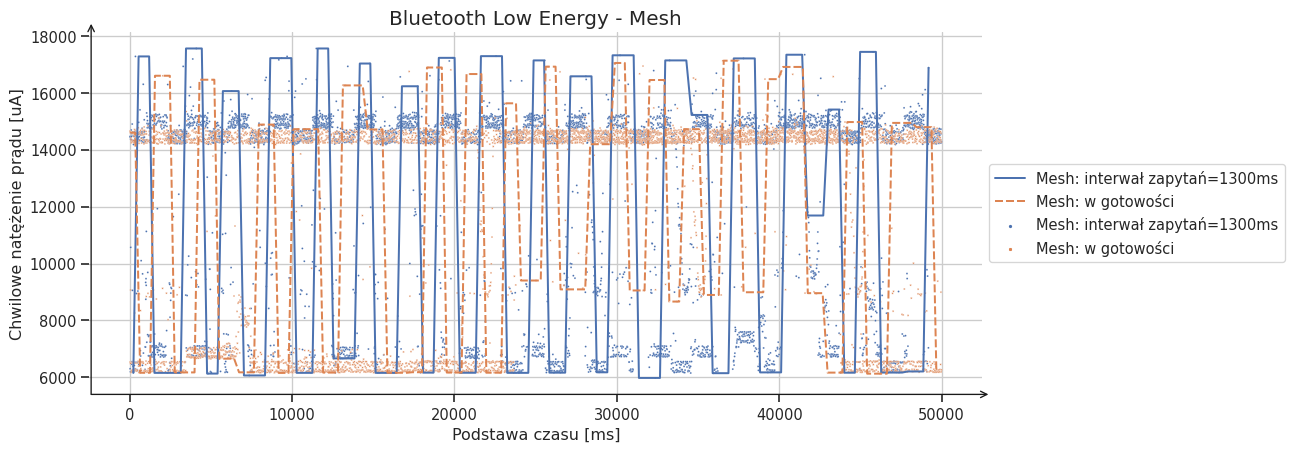

In [41]:
plot_with_interpolation(data_mesh, "Bluetooth Low Energy - Mesh", 200, 4, 2) 

### Punkty charakterystyczne dla danych

I$_{średnio}$ [mA]  I$_{max}$ [mA]  I$_{min}$ [mA]     E [J]     P [mW]  \
0           12.616973           17.57           5.973  2.081303  41.626068   
1           12.045725           17.14           6.123  1.987199  39.743985   

                       Kategoria  
0  Mesh: interwał zapytań=1300ms  
1              Mesh: w gotowości

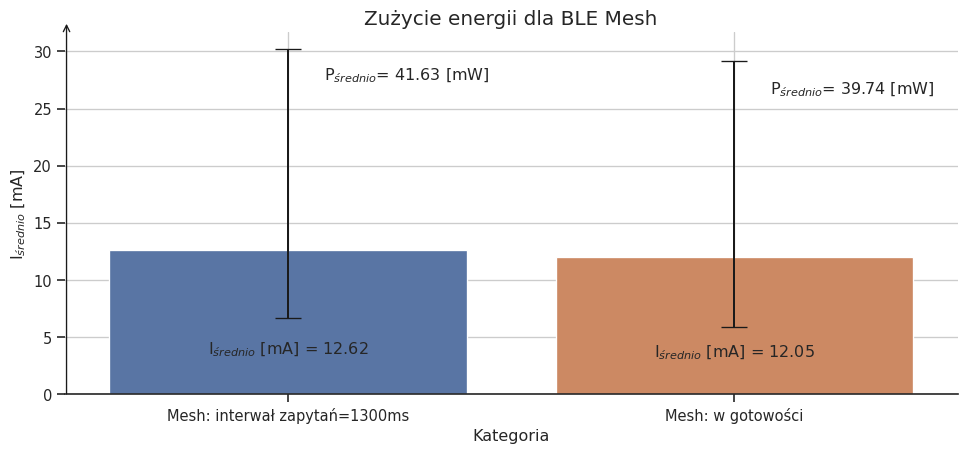

In [42]:
mesh_char = signal_characteristics_with_categories(data_mesh)
convert_amps_to_milli(mesh_char)

yerr = [mesh_char[CONST_CHAR_AMP_MIN_MILLIAMP], mesh_char[CONST_CHAR_AMP_MAX_MILLIAMP]]
ax = sns.barplot(data=mesh_char, x=CONST_CATEGORY, y=CONST_CHAR_AMP_MEAN_MILLIAMP, yerr=yerr)
ax.bar_label(ax.containers[-1], fmt=CONST_CHAR_AMP_MEAN_MILLIAMP + " = %.02f", label_type='center', padding=-20)
for p,energy,pwr in zip(ax.patches, mesh_char[CONST_CHAR_ENERGY], mesh_char[CONST_CHAR_POWER]):
    # ax.annotate("E$_{średnio}$ = %.02f [J]" % energy, xy=(p.get_x()+3*p.get_width()/5, p.get_height() * 2), ha='left', va='bottom')
    ax.annotate("P$_{średnio}$= %.02f [mW]" % pwr, xy=(p.get_x()+3*p.get_width()/5, p.get_height() * 2.15), ha='left', va='bottom')

ax.grid(True, axis='both')      
sns.despine(top=True, right=True, left=True)
# Y Axis arrow
ax.annotate('', xy=(0.002, 1.03), xytext=(0.002, -0.006), xycoords="axes fraction",
    weight='bold', color="k", arrowprops=dict(arrowstyle='->', color="k"), annotation_clip=False)
plt.title("Zużycie energii dla BLE Mesh", fontdict={"fontsize": 15})
mesh_char

## Porównanie

In [43]:
CONST_HRT = "HRT"
CONST_MESH = "Mesh"
ble_hrt_1 = pd.read_csv("ble_hrt_connected.csv", delimiter=';')
ble_hrt_2 = pd.read_csv("ble_hrt_discovery.csv", delimiter=';')  
ble_hrt_3 = pd.read_csv("ble_hrt_long_discovery.csv", delimiter=';')
ble_mesh_1 = pd.read_csv("ble_mesh_ping_1300.csv", delimiter=';')
ble_mesh_2 = pd.read_csv("ble_mesh_standby.csv", delimiter=';')

rename_columns(ble_hrt_1, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_hrt_2, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_hrt_3, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_mesh_1, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))
rename_columns(ble_mesh_2, ("ms", "uA"), (CONST_TIMESTAMP, CONST_AMPERAGE))

ble_hrt_1[CONST_CATEGORY] = CONST_HRT
ble_hrt_2[CONST_CATEGORY] = CONST_HRT
ble_hrt_3[CONST_CATEGORY] = CONST_HRT
ble_mesh_1[CONST_CATEGORY] = CONST_MESH
ble_mesh_2[CONST_CATEGORY] = CONST_MESH

data_all = pd.concat([ble_hrt_1, ble_hrt_2, ble_hrt_3, ble_mesh_1, ble_mesh_2])

I$_{średnio}$ [mA]  I$_{max}$ [mA]  I$_{min}$ [mA]     E [J]     P [mW]  \
0           12.331349           17.57           5.973  4.069003  40.690027   
1            0.586712           12.21           0.350  0.290408   1.936053   

  Kategoria  
0      Mesh  
1       HRT

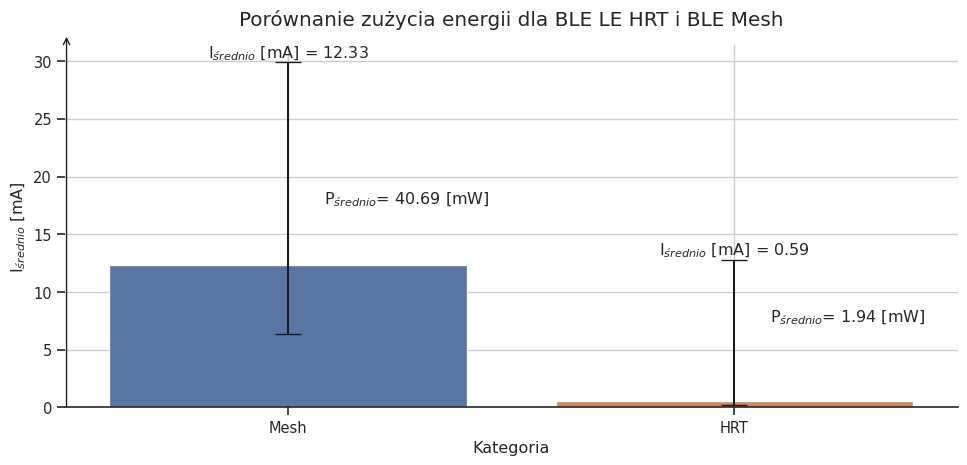

In [44]:
sig_char_mesh = compute_signal_characteristics(data_all[data_all[CONST_CATEGORY] == CONST_MESH], duration_ms=100000)
sig_char_mesh[CONST_CATEGORY] = CONST_MESH
sig_char_hrt = compute_signal_characteristics(data_all[data_all[CONST_CATEGORY] == CONST_HRT], duration_ms=150000)
sig_char_hrt[CONST_CATEGORY] = CONST_HRT
sig_char_all = pd.DataFrame([sig_char_mesh, sig_char_hrt])
convert_amps_to_milli(sig_char_all)

yerr = [sig_char_all[CONST_CHAR_AMP_MIN_MILLIAMP], sig_char_all[CONST_CHAR_AMP_MAX_MILLIAMP]]
ax = sns.barplot(data=sig_char_all, x=CONST_CATEGORY, y=CONST_CHAR_AMP_MEAN_MILLIAMP, yerr=yerr)
ax.bar_label(ax.containers[-1], fmt=CONST_CHAR_AMP_MEAN_MILLIAMP + " = %.02f", label_type='edge')
p=ax.patches
# ax.annotate("E$_{średnio}$ = %.02f [J]" % sig_char_all[sig_char_all[CONST_CATEGORY] == CONST_MESH][CONST_CHAR_ENERGY], xy=(p[0].get_x()+3*p[0].get_width()/5, p[0].get_height() * 1.25), ha='left', va='bottom')
ax.annotate("P$_{średnio}$= %.02f [mW]" % sig_char_all[sig_char_all[CONST_CATEGORY] == CONST_MESH][CONST_CHAR_POWER], xy=(p[0].get_x()+3*p[0].get_width()/5, p[0].get_height() * 1.40), ha='left', va='bottom')
# ax.annotate("E$_{średnio}$ = %.02f [J]" % sig_char_all[sig_char_all[CONST_CATEGORY] == CONST_HRT][CONST_CHAR_ENERGY], xy=(p[1].get_x()+3*p[1].get_width()/5, p[1].get_height() * 9), ha='left', va='bottom')
ax.annotate("P$_{średnio}$= %.02f [mW]" % sig_char_all[sig_char_all[CONST_CATEGORY] == CONST_HRT][CONST_CHAR_POWER], xy=(p[1].get_x()+3*p[1].get_width()/5, p[1].get_height() * 12), ha='left', va='bottom')

ax.grid(True, axis='both')      
sns.despine(top=True, right=True, left=True)
# Y Axis arrow
ax.annotate('', xy=(0.002, 1.03), xytext=(0.002, -0.006), xycoords="axes fraction",
    weight='bold', color="k", arrowprops=dict(arrowstyle='->', color="k"), annotation_clip=False)
plt.title("Porównanie zużycia energii dla BLE LE HRT i BLE Mesh", fontdict={"fontsize": 15}, pad=15)

sig_char_all  # pozbyć się Dżuli [J]!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!